# Results Processing

## Imports and variables used throughout file

Load results dataframe from pickle file

In [6]:
from dir_paths import PROCESSED_DATA_DIR, FIGURES_SIMULATIONS_DIR
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import numpy as np

# Configure matplotlib to use LaTeX
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": [10, 6],
    "savefig.dpi": 300,
    "savefig.format": "pdf"
})

# Load results_df from pickle file
results_df = pd.read_pickle(f"{PROCESSED_DATA_DIR}/results_df.pkl")

## Miss ratio vs. relative cache size, linear and log scale

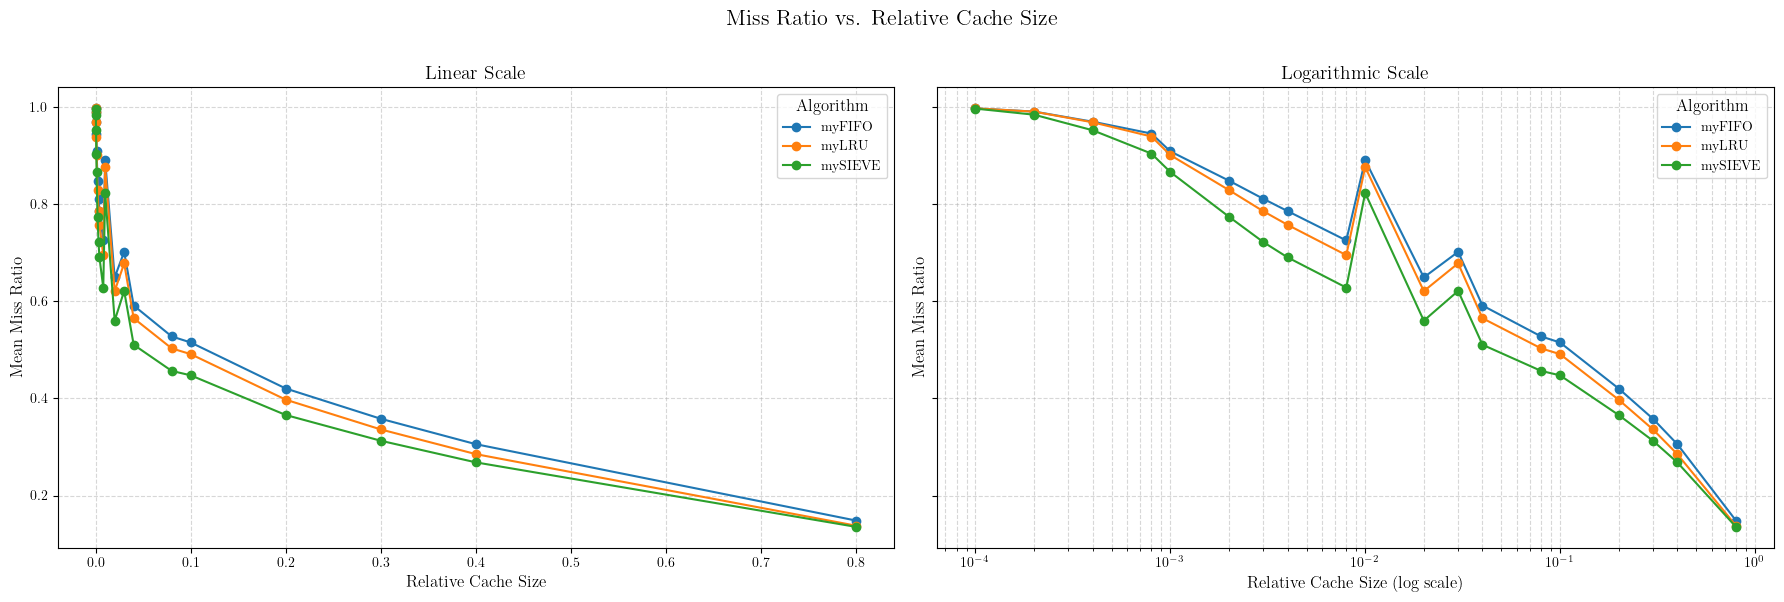

In [7]:
# Group by algorithm and cache_size_relative_rounded, aggregate mean miss ratio
agg_mean = results_df.groupby(['algorithm', 'cache_size_relative_rounded'])['miss_ratio'].mean().reset_index()
filenames = {"both" : "miss_ratio_vs_cache_size_both.pdf",
             "log" : "miss_ratio_vs_cache_size_log.pdf",
             "linear" : "miss_ratio_vs_cache_size_linear.pdf"}

def plot_miss_ratio_vs_cache_size_no_error(
    agg_df,
    scale='both',
    figsize=(18, 6),
    marker='o',
    save_fig=False
):
    """
    Plot miss ratio vs. relative cache size without error bars.

    Parameters:
        agg_df (pd.DataFrame): Aggregated dataframe with columns ['algorithm', 'cache_size_relative_rounded', 'miss_ratio']
        scale (str): 'linear', 'log', or 'both'
        figsize (tuple): Figure size
        marker (str): Marker style
    """
    scales = []

    if scale == 'both':
        scales = ['linear', 'log']
    else:
        scales = [scale]
        
    n_plots = len(scales)
    _, axs = plt.subplots(1, n_plots, figsize=figsize,
                          sharey=True if n_plots > 1 else False)

    if n_plots == 1:
        axs = [axs]

    if scale == 'both': plt.suptitle('Miss Ratio vs. Relative Cache Size', fontsize=16, y=1)

    for i, sc in enumerate(scales):
        for algo in agg_df['algorithm'].unique():
            df_algo = agg_df[agg_df['algorithm'] == algo]
            axs[i].plot(
                df_algo['cache_size_relative_rounded'],
                df_algo['miss_ratio'],
                marker=marker,
                label=algo
            )
        axs[i].set_xlabel('Relative Cache Size' +
                          (' (log scale)' if sc == 'log' else ''))
        axs[i].set_ylabel('Mean Miss Ratio')

        # Add main title above both subplots if more than one algorithm is present and both scales are plotted
        if len(agg_df['algorithm'].unique()) > 1 and n_plots > 1:
            axs[i].set_title('Logarithmic Scale' if sc == 'log' else 'Linear Scale')
        else:
            axs[i].set_title("Miss Ratio vs. Relative Cache Size" + (" (log scale)" if sc == 'log' else ""), fontsize=16)
        axs[i].grid(True, which='both', linestyle='--', alpha=0.5)

        axs[i].legend(title='Algorithm')

        if sc == 'log':
            axs[i].set_xscale('log')

    plt.tight_layout()

    if save_fig:
        plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, filenames[scale]), bbox_inches='tight')
    plt.show()

plot_miss_ratio_vs_cache_size_no_error(agg_mean, scale='both', save_fig=False)


## Miss ratio vs. alpha

### Line plot

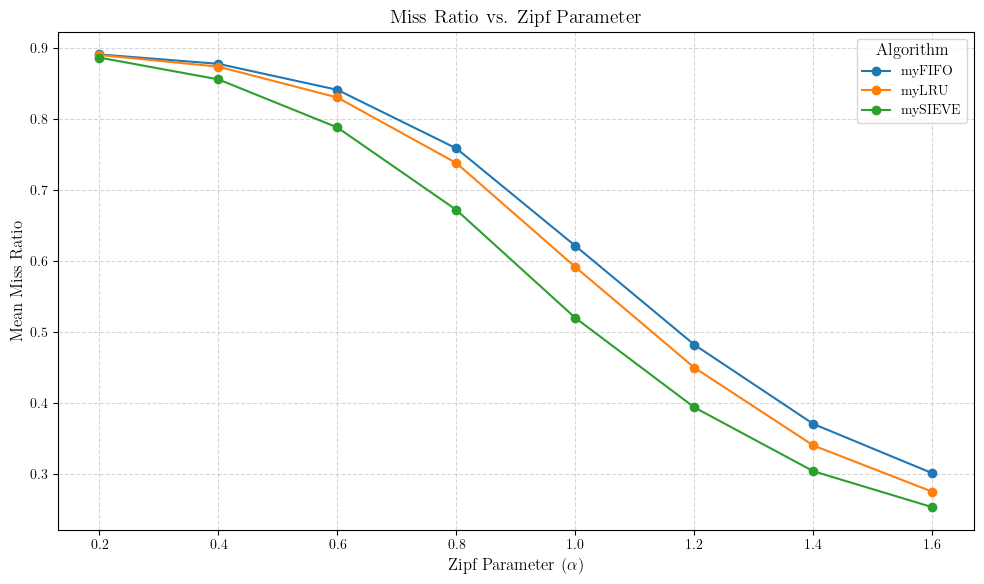

In [8]:
# Aggregate mean miss ratio by algorithm and alpha
zipf_agg = results_df.groupby(['algorithm', 'alpha'])['miss_ratio'].mean().reset_index()

plt.figure(figsize=(10, 6))
for algo in zipf_agg['algorithm'].unique():
    df_algo = zipf_agg[zipf_agg['algorithm'] == algo]
    plt.plot(df_algo['alpha'], df_algo['miss_ratio'], marker='o', label=algo)

plt.xlabel(r'Zipf Parameter ($\alpha$)')
plt.ylabel('Mean Miss Ratio')
plt.title('Miss Ratio vs. Zipf Parameter')
plt.legend(title='Algorithm')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Scatter plot, colored by relative cache size and shaped by algorithm

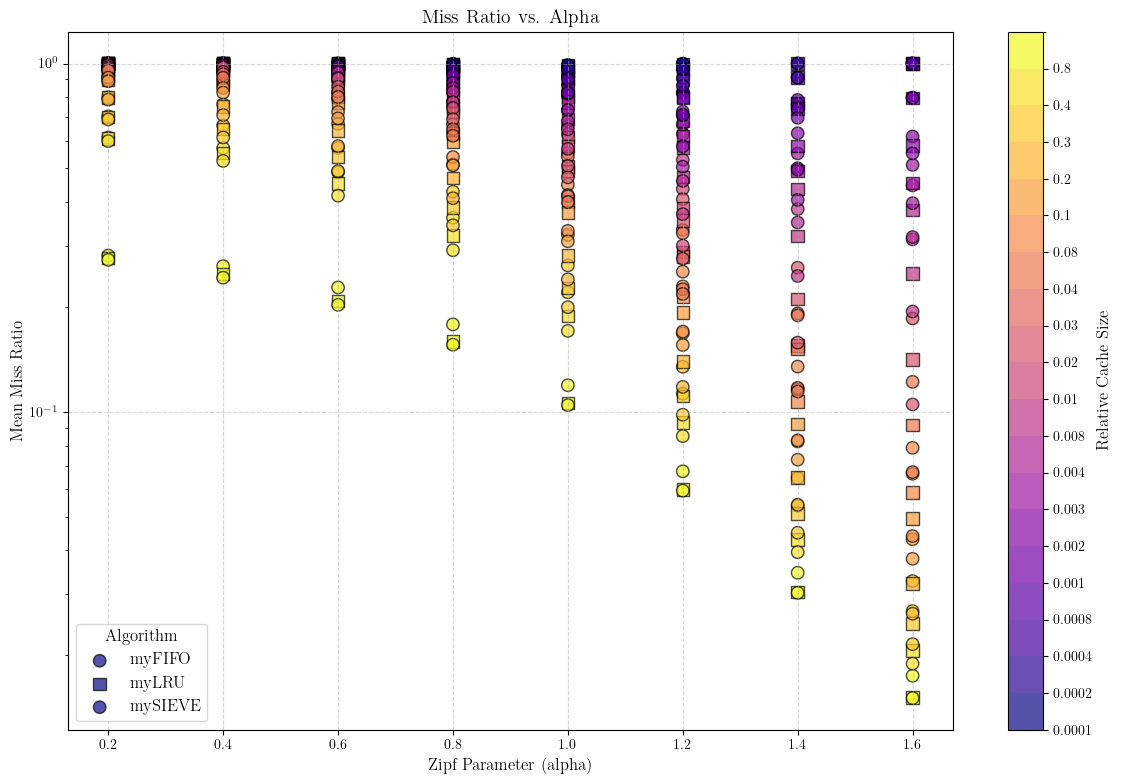

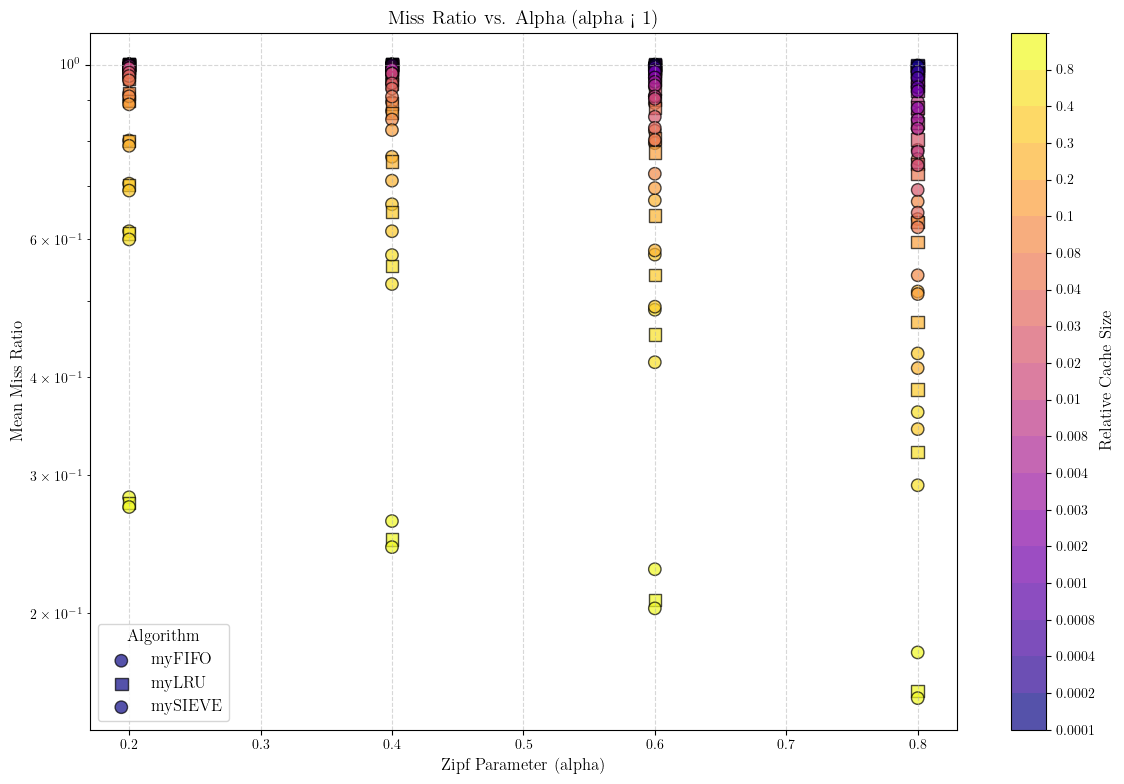

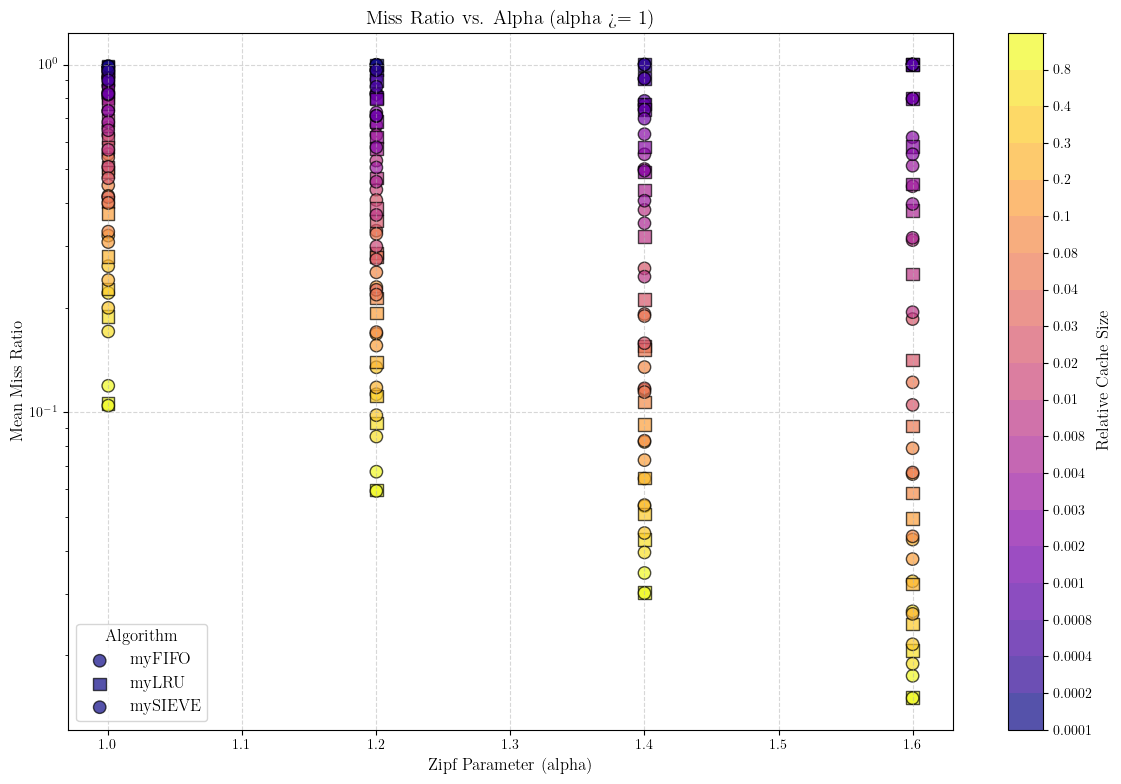

In [9]:
# Pivot the data to have (alpha, cache_size_relative_rounded) as x, algorithm as lines
pivot_df = results_df.groupby(['algorithm', 'alpha', 'cache_size_relative_rounded'])['miss_ratio'].mean().reset_index()

# Assign a unique marker for each algorithm
markers = {
    'myFIFO': 'o',
    'myLRU': 's',
    'mySieve': '^'
}

cmap = 'plasma'

# Only use the specified relative cache sizes
relevant_sizes = sorted(pivot_df['cache_size_relative_rounded'].unique())
filtered_df = pivot_df[pivot_df['cache_size_relative_rounded'].isin(relevant_sizes)]

# # Create a colormap and norm that matches the relevant sizes
cmap = plt.get_cmap('plasma', len(relevant_sizes))
norm = mpl.colors.BoundaryNorm(boundaries=np.append(relevant_sizes, relevant_sizes[-1]+0.001), ncolors=len(relevant_sizes))

# Split the filtered_df into two based on alpha
below_1 = filtered_df[filtered_df['alpha'] < 1]
above_eq_1 = filtered_df[filtered_df['alpha'] >= 1]

def plot_scatter(df, title):
    plt.figure(figsize=(12, 8))
    scs = []
    for algo in df['algorithm'].unique():
        df_algo = df[df['algorithm'] == algo]
        sc = plt.scatter(
            df_algo['alpha'],
            df_algo['miss_ratio'],
            c=df_algo['cache_size_relative_rounded'],
            cmap=cmap,
            norm=norm,
            s=80,
            alpha=0.7,
            marker=markers.get(algo, 'o'),
            label=algo,
            edgecolor='black'
        )
        scs.append(sc)
    plt.xlabel('Zipf Parameter (alpha)')
    plt.ylabel('Mean Miss Ratio')
    plt.title(title)
    plt.yscale('log')
    cbar = plt.colorbar(scs[0], ticks=relevant_sizes, label='Relative Cache Size')
    cbar.ax.set_yticklabels([str(s) for s in relevant_sizes])
    plt.legend(title='Algorithm', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_scatter(filtered_df, "Miss Ratio vs. Alpha")
plot_scatter(below_1, 'Miss Ratio vs. Alpha (alpha < 1)')
plot_scatter(above_eq_1, 'Miss Ratio vs. Alpha (alpha >= 1)')

## Miss ratio distribution

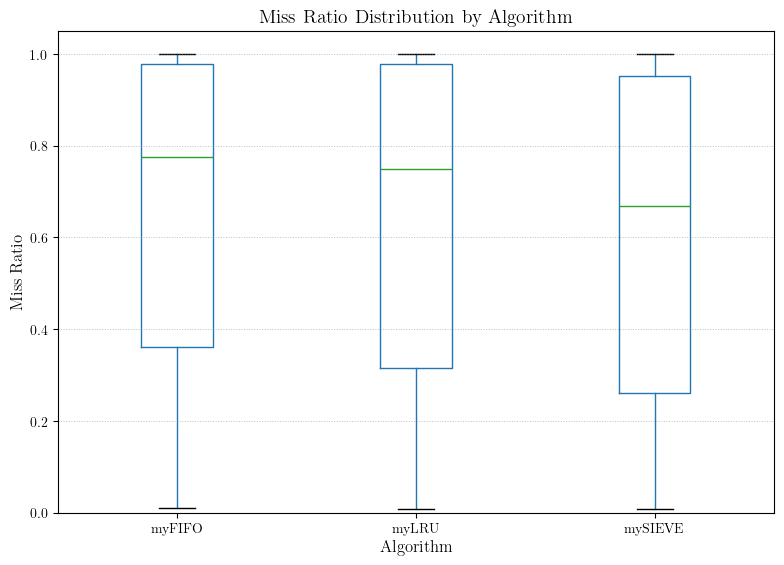

In [10]:
plt.figure(figsize=(8, 6))
ax = plt.gca()
results_df.boxplot(column='miss_ratio', by='algorithm', ax=ax, grid=False)
plt.title('Miss Ratio Distribution by Algorithm')
plt.suptitle('')
plt.xlabel('Algorithm')
plt.ylabel('Miss Ratio')
plt.tight_layout()
ax.set_ylim(0, 1.05)

for y in ax.get_yticks():
    ax.axhline(y, color='gray', linestyle=':', linewidth=0.7, alpha=0.5)

plt.show()

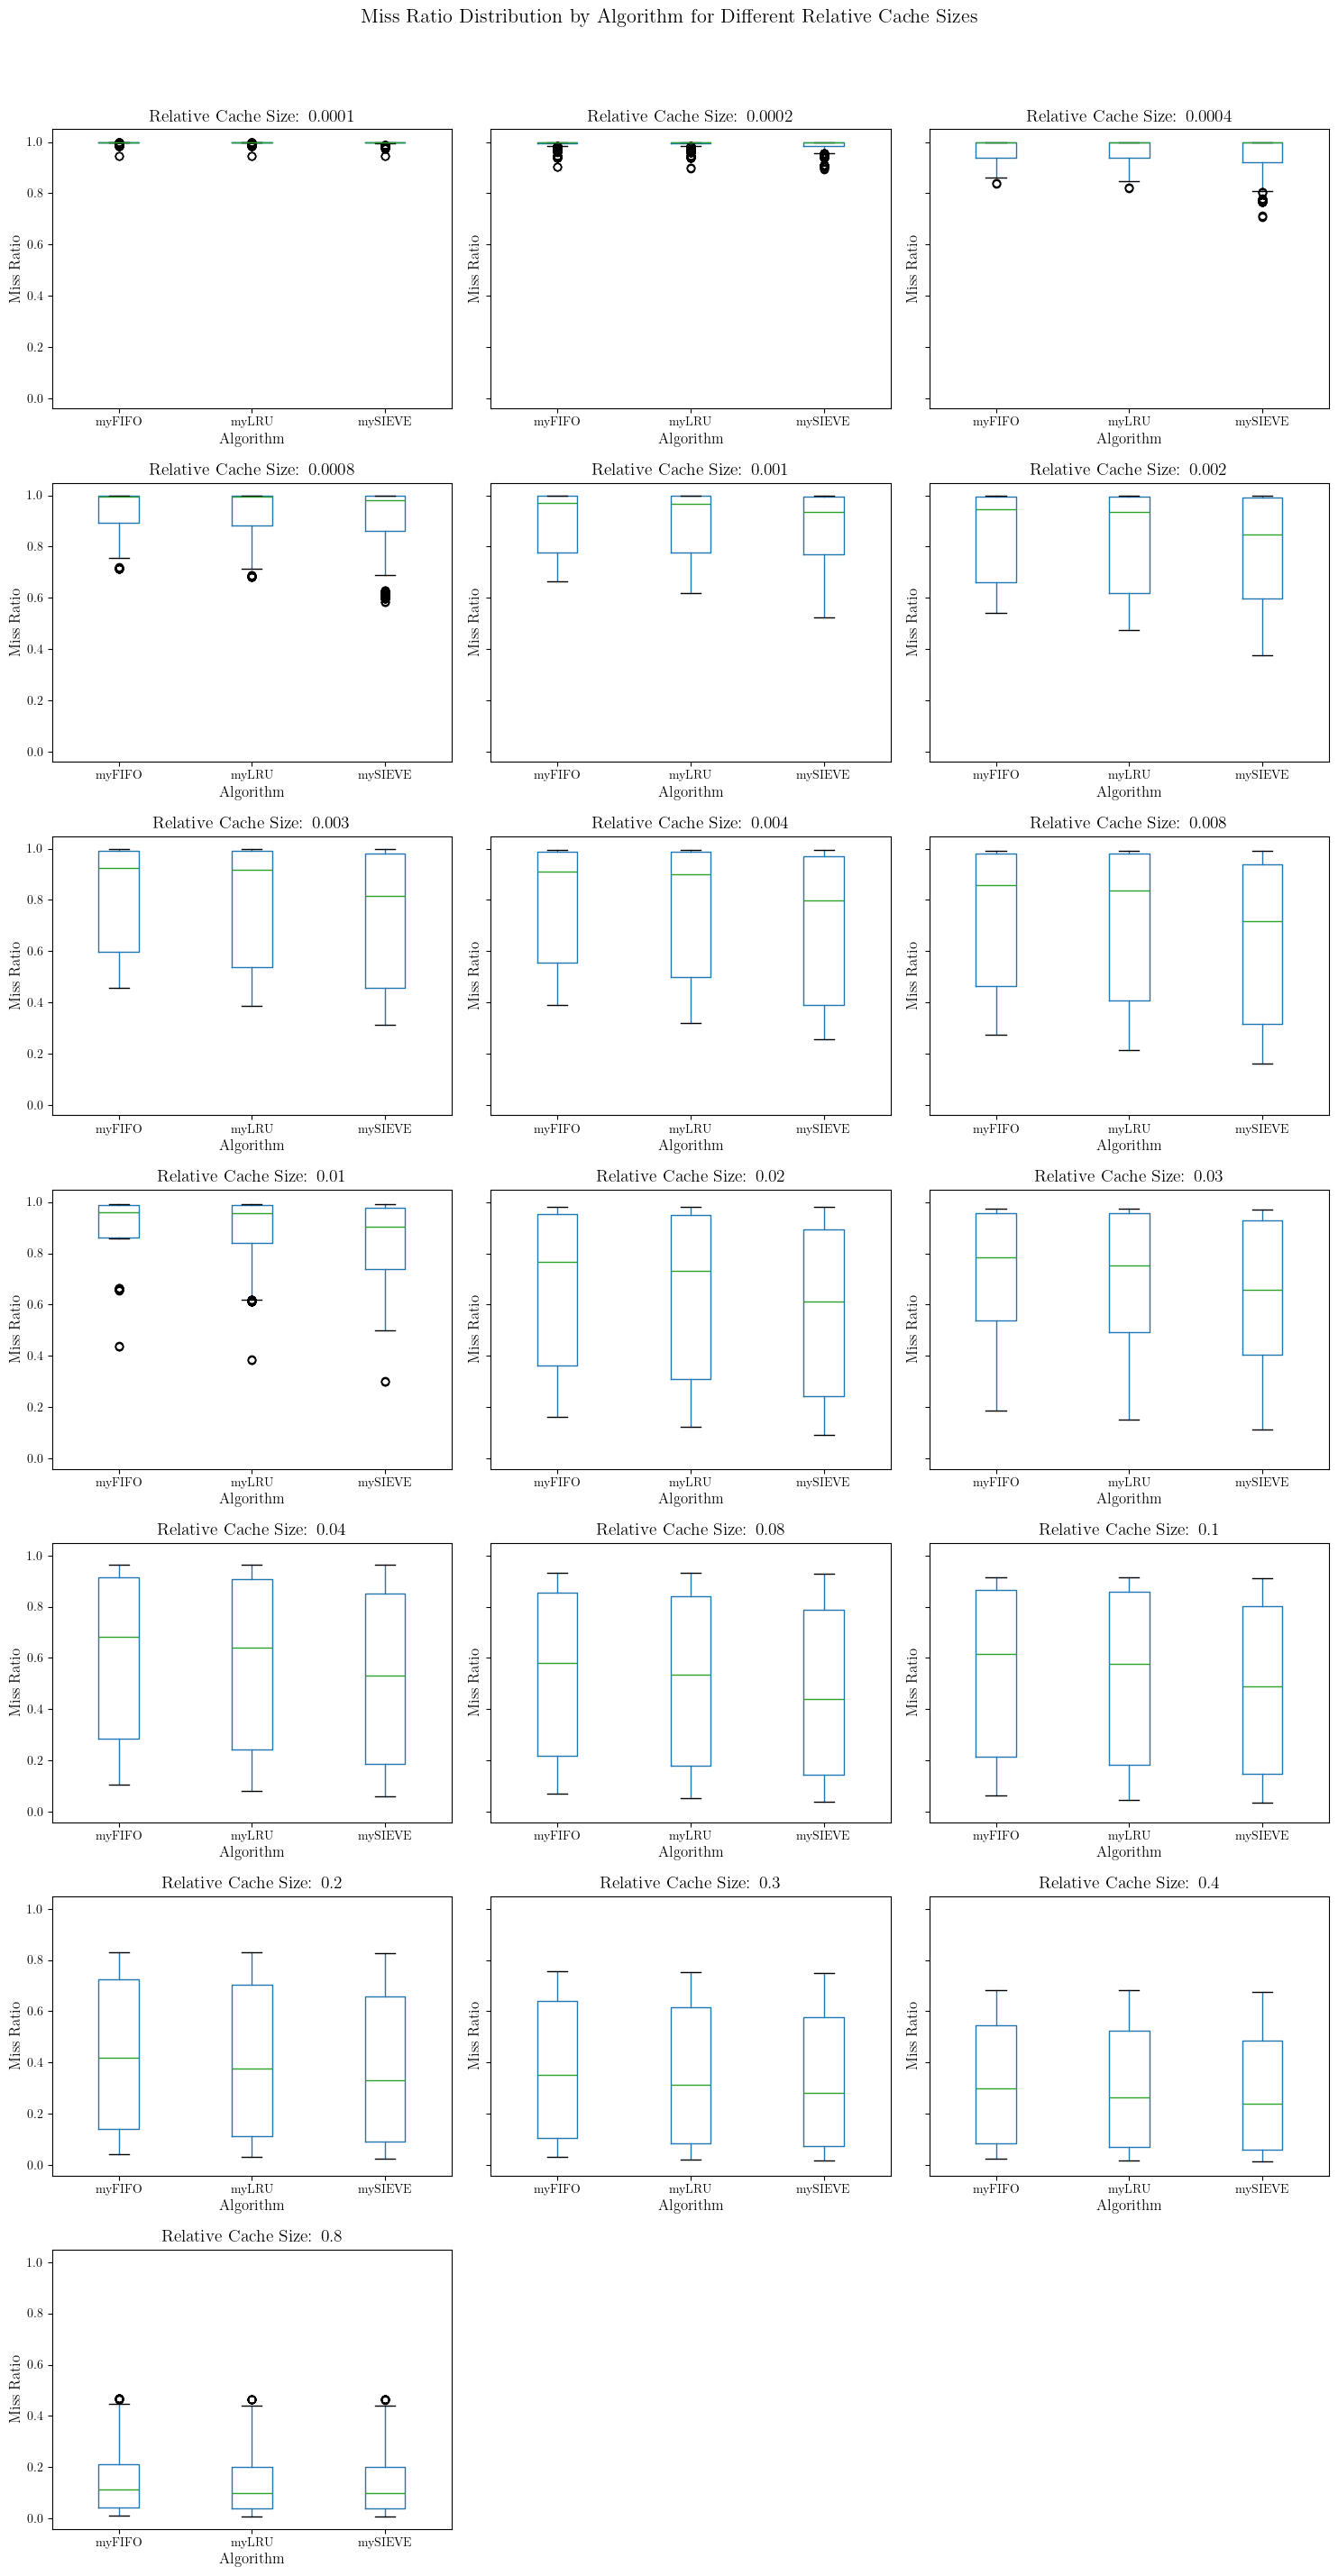

In [11]:
# Plot miss ratio distribution per algorithm for each relative cache size using boxplots and violin plots
unique_sizes = sorted(results_df['cache_size_relative_rounded'].unique())
n_sizes = len(unique_sizes)
n_cols = 3
n_rows = (n_sizes + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)
axs = axs.flatten()

for i, size in enumerate(unique_sizes):
    subset = results_df[results_df['cache_size_relative_rounded'] == size]
    ax = axs[i]
    subset.boxplot(column='miss_ratio', by='algorithm', ax=ax, grid=False)
    ax.set_title(f'Relative Cache Size: {size}')
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Miss Ratio')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Miss Ratio Distribution by Algorithm for Different Relative Cache Sizes', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

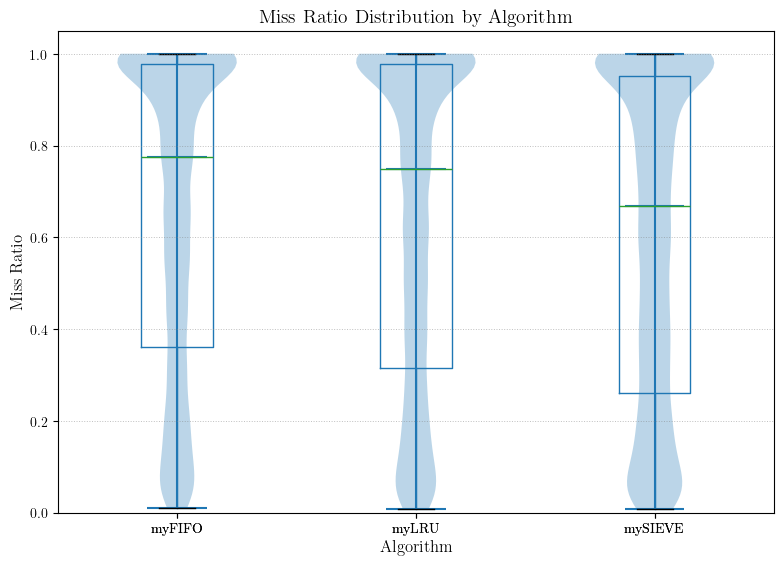

In [12]:
plt.figure(figsize=(8, 6))
subset_violin = [results_df[results_df['algorithm'] == algo]['miss_ratio'] for algo in results_df['algorithm'].unique()]
plt.violinplot(subset_violin, showmeans=False, showmedians=True)
plt.xticks(range(1, len(results_df['algorithm'].unique()) + 1), results_df['algorithm'].unique())
ax = plt.gca()
results_df.boxplot(column='miss_ratio', by='algorithm', ax=ax, grid=False)
plt.title('Miss Ratio Distribution by Algorithm')
plt.suptitle('')
plt.xlabel('Algorithm')
plt.ylabel('Miss Ratio')
plt.tight_layout()
ax.set_ylim(0, 1.05)

for y in ax.get_yticks():
    ax.axhline(y, color='gray', linestyle=':', linewidth=0.7, alpha=0.5)

plt.show()

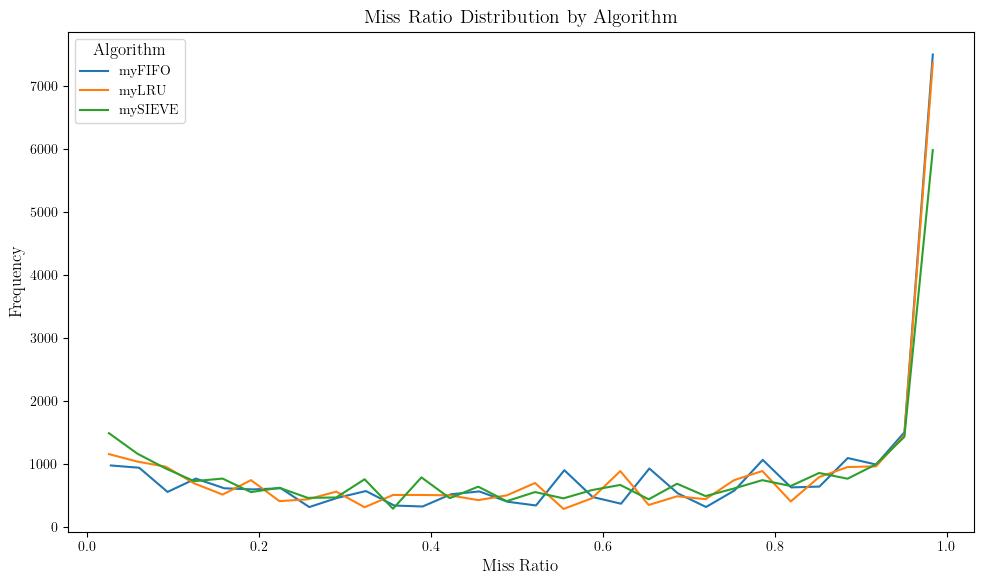

In [13]:
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    counts, bin_edges = np.histogram(data, bins=30)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, counts, label=algo)
plt.xlabel('Miss Ratio')
plt.ylabel('Frequency')
plt.title('Miss Ratio Distribution by Algorithm')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()

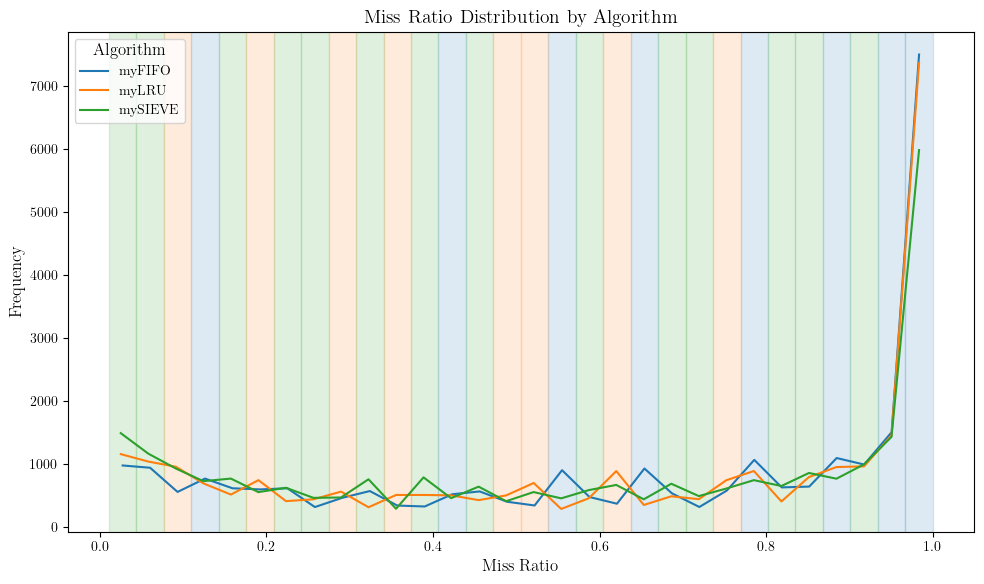

In [14]:
plt.figure(figsize=(10, 6))

# Store histogram data for each algorithm
hist_data = {}
bin_edges = None

for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    counts, edges = np.histogram(data, bins=30)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    hist_data[algo] = counts
    if bin_edges is None:
        bin_edges = edges
    plt.plot(bin_centers, counts, label=algo)

# Find the algorithm with the highest frequency for each bin
all_counts = np.array([hist_data[algo] for algo in results_df['algorithm'].unique()])
max_algo_idx = np.argmax(all_counts, axis=0)
algos = list(results_df['algorithm'].unique())
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(len(bin_edges) - 1):
    algo_idx = max_algo_idx[i]
    plt.axvspan(bin_edges[i], bin_edges[i+1], color=colors[algo_idx], alpha=0.15)

plt.xlabel('Miss Ratio')
plt.ylabel('Frequency')
plt.title('Miss Ratio Distribution by Algorithm')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()

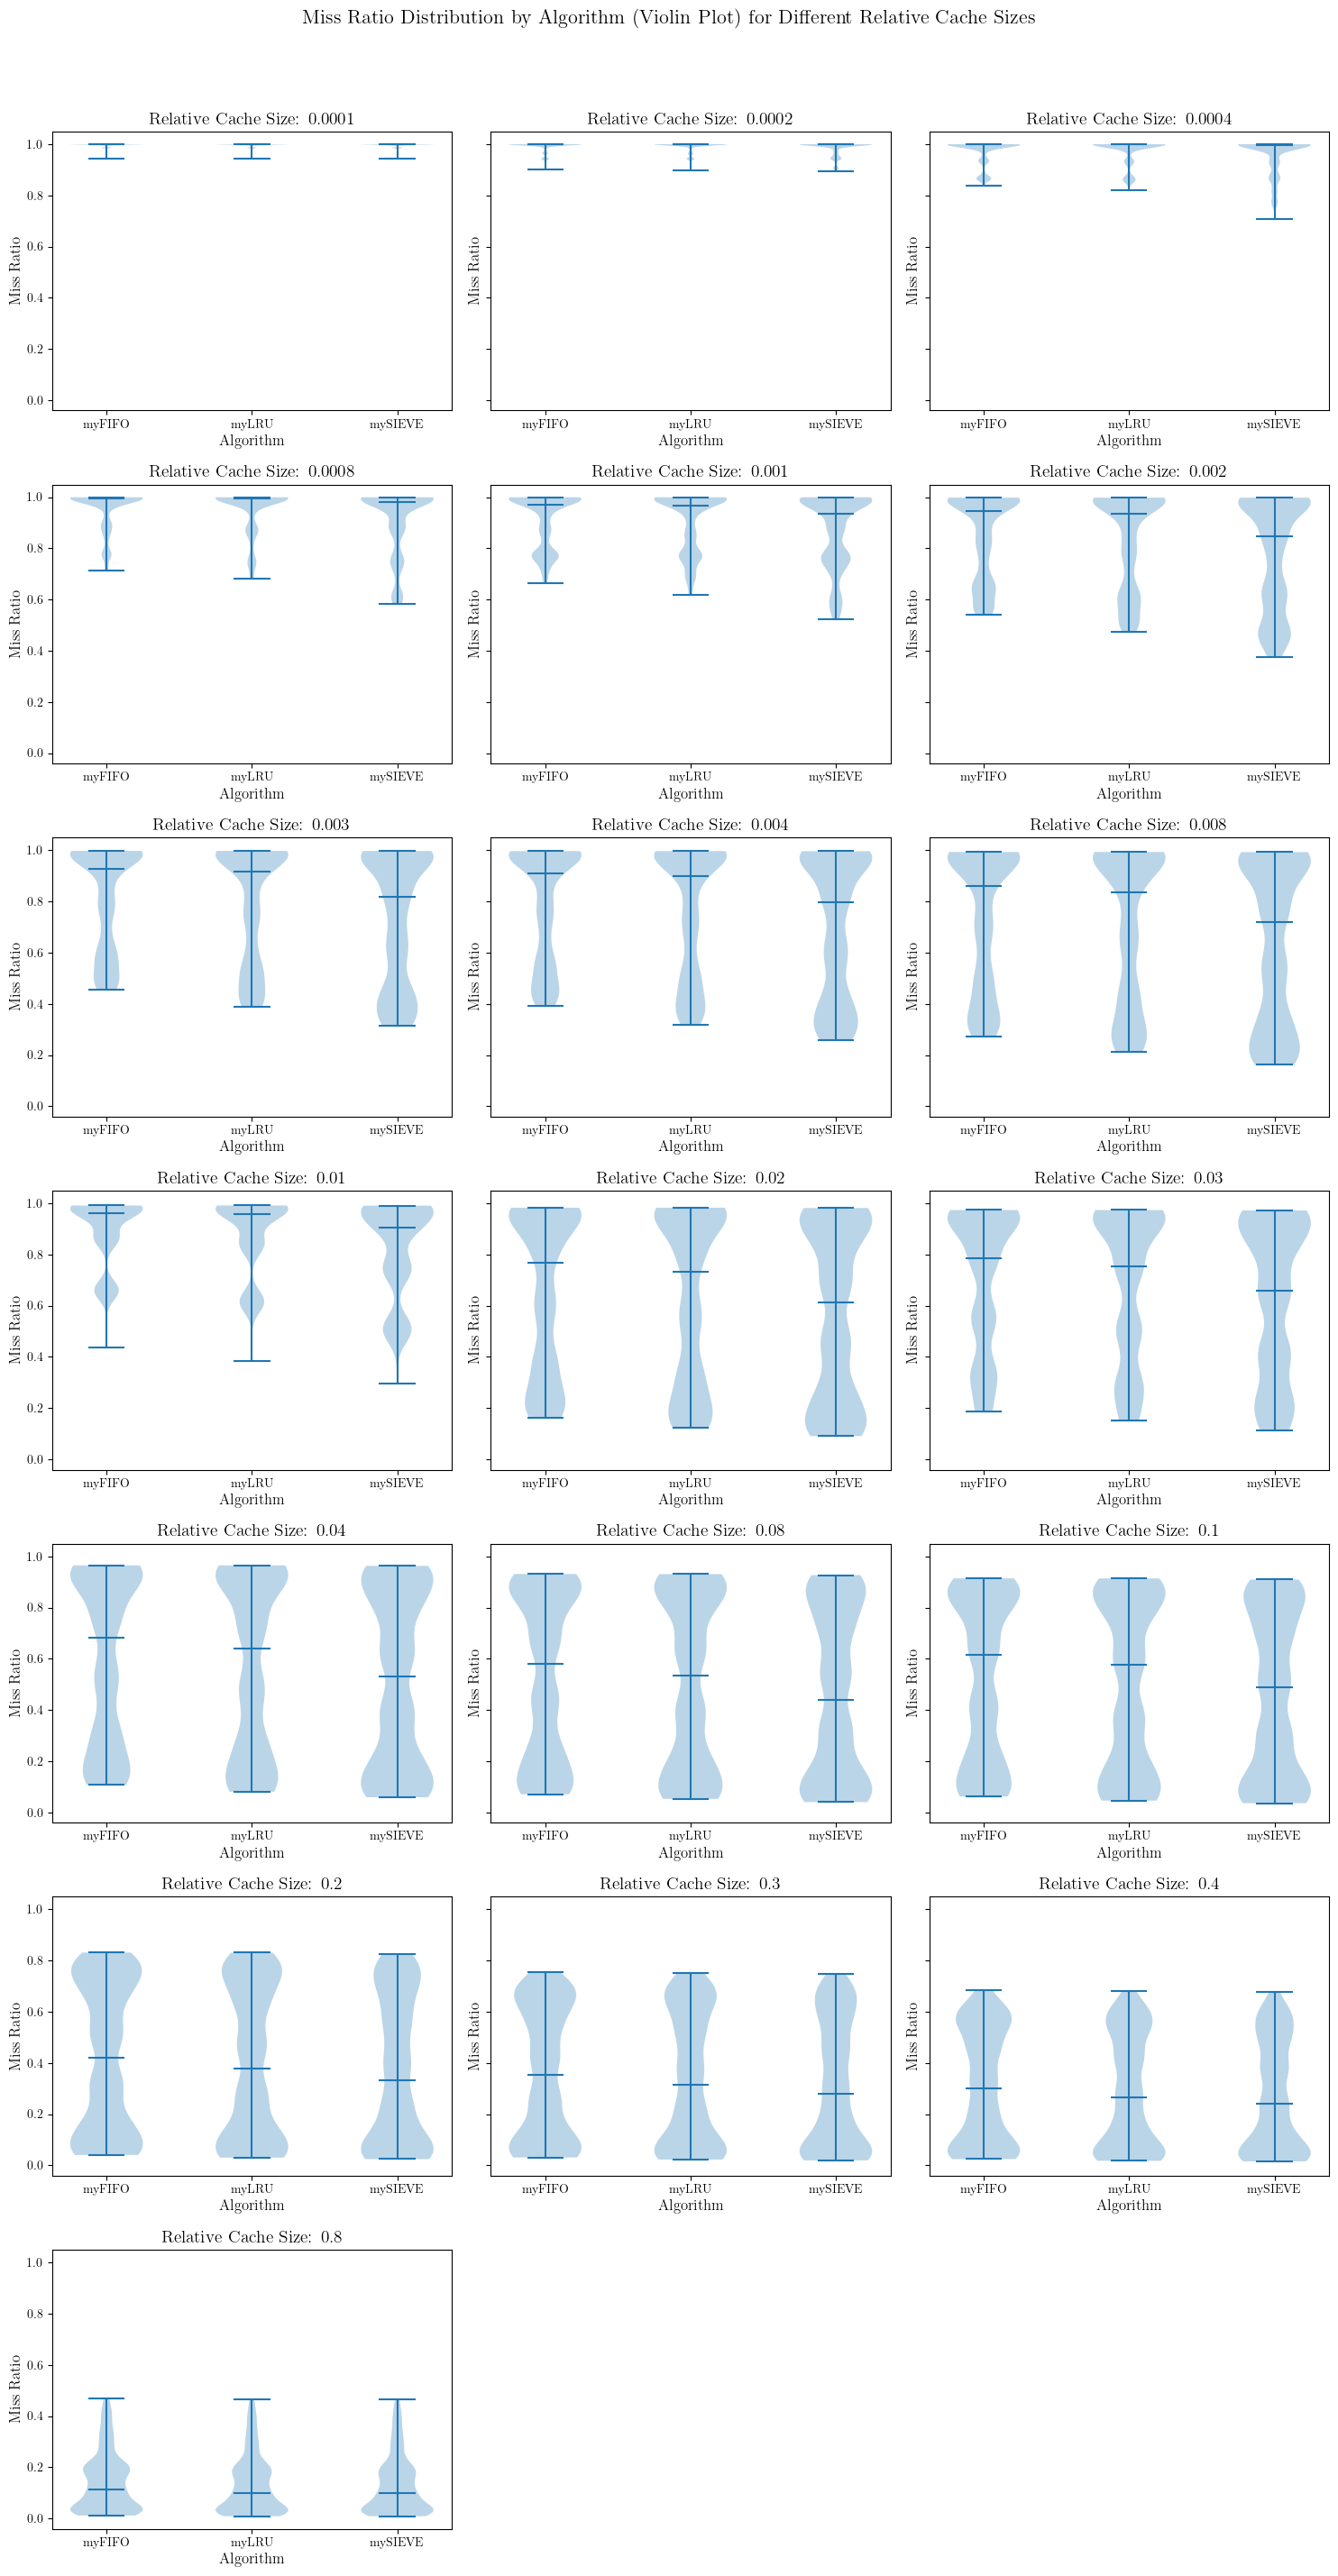

In [15]:
# Violin plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)
axs = axs.flatten()

for i, size in enumerate(unique_sizes):
    subset = results_df[results_df['cache_size_relative_rounded'] == size]
    ax = axs[i]
    subset_violin = [subset[subset['algorithm'] == algo]['miss_ratio'] for algo in subset['algorithm'].unique()]
    ax.violinplot(subset_violin, showmeans=False, showmedians=True)
    ax.set_xticks(range(1, len(subset['algorithm'].unique()) + 1))
    ax.set_xticklabels(subset['algorithm'].unique())
    ax.set_title(f'Relative Cache Size: {size}')
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Miss Ratio')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Miss Ratio Distribution by Algorithm (Violin Plot) for Different Relative Cache Sizes', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()